In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark -q

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gsutil -m cp -r gs://weather-2024/csv /content/

Traceback (most recent call last):
  File "/tools/google-cloud-sdk/platform/gsutil/gsutil", line 21, in <module>
    gsutil.RunMain()
  File "/tools/google-cloud-sdk/platform/gsutil/gsutil.py", line 157, in RunMain
^C


## Step 0. Load data

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import (
    StructType, StructField, StringType, TimestampType, DoubleType
)
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

spark = SparkSession.builder.appName("QC_Weather_Processing_Dataproc").getOrCreate()


input_path = "/content/csv/*.csv"


cols_to_keep = [
    "STATION", "DATE", "LATITUDE", "LONGITUDE", "ELEVATION",
    "TMP", "DEW", "WND", "VIS", "CIG", "SLP"
]
manual_schema = StructType([
    StructField("STATION", StringType(), True),
    StructField("DATE", StringType(), True),
    StructField("LATITUDE", StringType(), True), 
    StructField("LONGITUDE", StringType(), True), 
    StructField("ELEVATION", StringType(), True), 
    StructField("TMP", StringType(), True), 
    StructField("DEW", StringType(), True), 
    StructField("WND", StringType(), True), 
    StructField("VIS", StringType(), True), 
    StructField("CIG", StringType(), True), 
    StructField("SLP", StringType(), True) 
])
df_full = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv(input_path)
df = df_full.select(*cols_to_keep)
print("Step 0: Total rows read:", df.count())

Step 0: Total rows read: 2881145


In [ ]:
df.show(3)

+-----------+-------------------+--------+---------+---------+----+-------------+-----+-----+----+--------------+
|    STATION|               DATE|LATITUDE|LONGITUDE|ELEVATION| TMP|          DEW|  WND|  VIS| CIG|           SLP|
+-----------+-------------------+--------+---------+---------+----+-------------+-----+-----+----+--------------+
|01023099999|2024-01-01T00:00:00|       4|69.055758|18.540356|76.8|BARDUFOSS, NO|FM-12|99999|V020|999,9,C,0000,5|
|01023099999|2024-01-01T00:20:00|       4|69.055758|18.540356|76.8|BARDUFOSS, NO|FM-15|99999|V020|999,9,V,0010,1|
|01023099999|2024-01-01T00:50:00|       4|69.055758|18.540356|76.8|BARDUFOSS, NO|FM-15|99999|V020|310,1,N,0010,1|
+-----------+-------------------+--------+---------+---------+----+-------------+-----+-----+----+--------------+
only showing top 3 rows



Original dataset size: 130222106


## Step 1. Delete stations

### stations with too few rows

In [ ]:
station_record_counts = df.groupBy("STATION").count().persist() 

In [ ]:
counts = station_record_counts.select("count").rdd.map(lambda r: r[0]).collect()

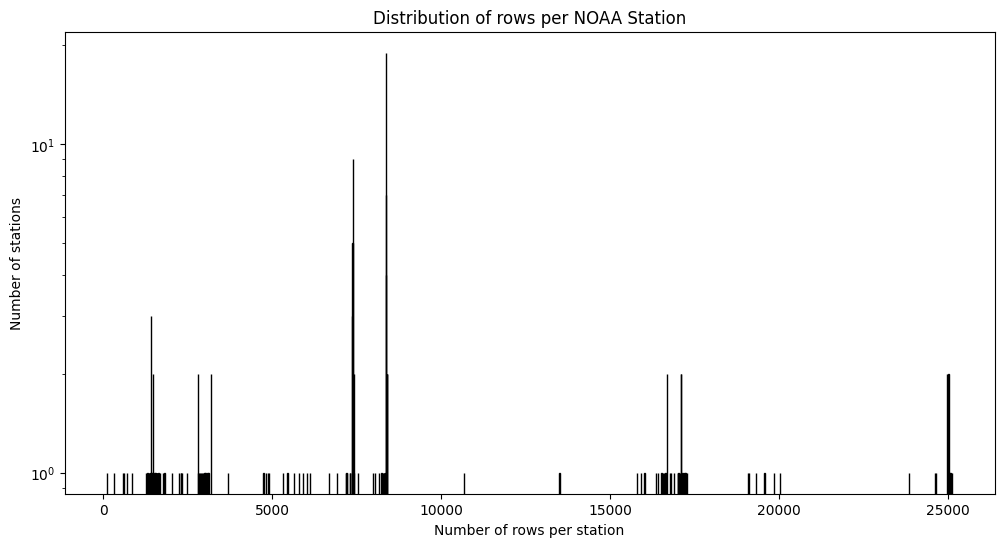

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(counts, bins=5000, color='skyblue', edgecolor='black')
plt.xlabel("Number of rows per station")
plt.ylabel("Number of stations")
plt.title("Distribution of rows per NOAA Station")
plt.yscale('log')  #
plt.show()
plt.savefig("/tmp/station_record_hist.png")

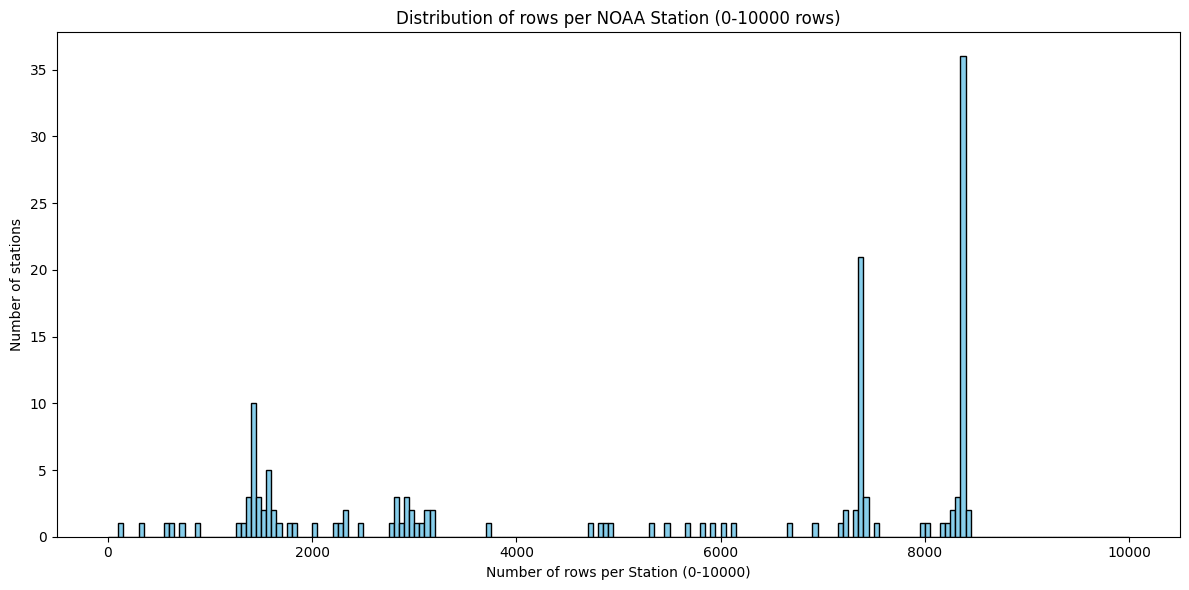

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(counts, bins=200, range=(0,10000), color='skyblue', edgecolor='black')
plt.xlabel("Number of rows per Station (0-10000)")
plt.ylabel("Number of stations")
plt.title("Distribution of rows per NOAA Station (0-10000 rows)")
plt.tight_layout()
plt.show()
plt.savefig("/tmp/station_record_hist_0_10000.png")

In [ ]:
thres = station_record_counts.approxQuantile("count", [0.05], 0.01)[0]
print("Step 1: threshold for station rows (5% quantile):", thres)

Step 1: threshold for station rows (5% quantile): 630.0


In [ ]:
keep_stations_df = station_record_counts.filter(F.col("count") > thres).select("STATION")

df_filtered = df.join(keep_stations_df, on="STATION", how="inner")
station_record_counts.unpersist()
df.unpersist()

DataFrame[STATION: string, DATE: string, LATITUDE: string, LONGITUDE: string, ELEVATION: string, TMP: string, DEW: string, WND: string, VIS: string, CIG: string, SLP: string]

In [ ]:
num_rows_total = station_record_counts.agg(F.sum("count")).first()[0]
num_rows_after = df_filtered.count()
num_total_csv = station_record_counts.count()
num_removed_csv = num_total_csv - keep_stations_df.count()

log_text = (
    f"Number of rows: {num_rows_total}\n"
    f"Number of rows after filtering: {num_rows_after}\n"
    f"Total number of CSV files: {num_total_csv}\n"
    f"Number of removed CSV files: {num_removed_csv}\n"
)
print(log_text)


Number of rows: 2881145
Number of rows after filtering: 2877889
Total number of CSV files: 393
Number of removed CSV files: 17



### stations with too large time interval

In [ ]:
from pyspark.sql.functions import to_timestamp, col, lag, asc, unix_timestamp
df_filtered = df_filtered.withColumn("DATE_TS", to_timestamp("DATE", "yyyy-MM-dd'T'HH:mm:ss"))

Min: 0.00, Max: 237060.00, Mean: 60.28


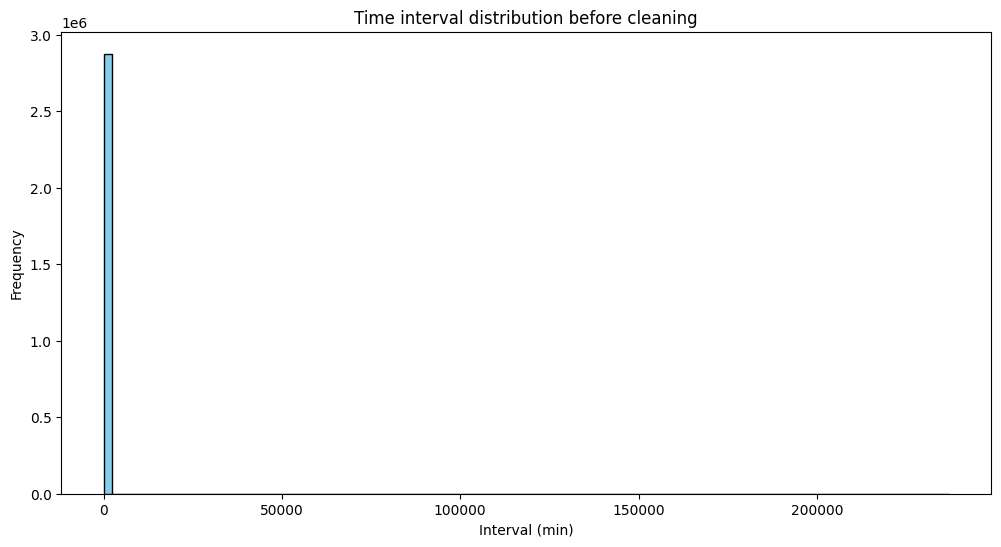

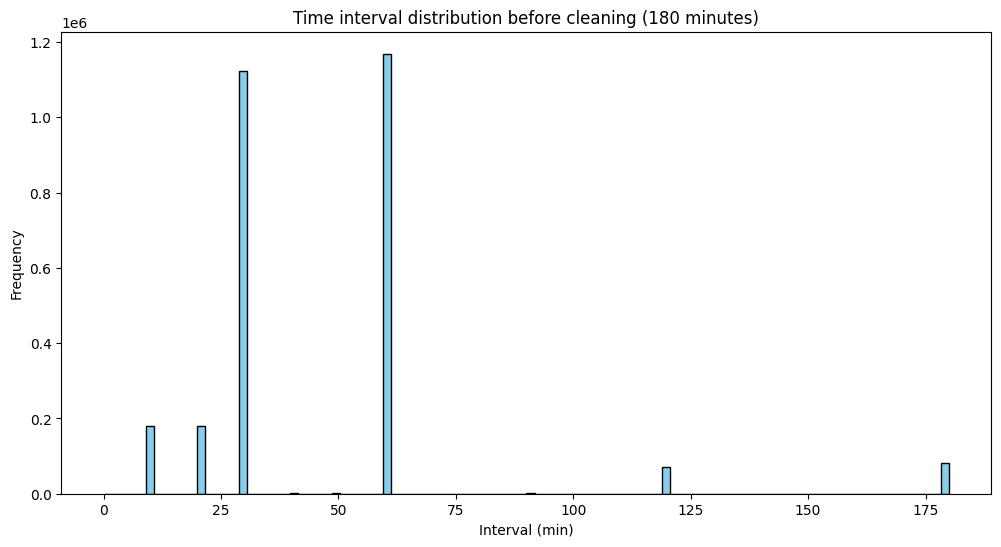

In [ ]:
from pyspark.sql import Window

before_cnt = df_filtered.count()

w = Window.partitionBy("STATION").orderBy(asc("DATE_TS"))

df_filtered = df_filtered.withColumn("dt_min", (unix_timestamp("DATE_TS") - unix_timestamp(lag("DATE_TS", 1).over(w)))/60) \
              .dropna(subset=["dt_min"])

min_interval, max_interval, mean_interval = df_filtered.agg(
    F.min("dt_min"), F.max("dt_min"), F.mean("dt_min")
).first()
print(f"Min: {min_interval:.2f}, Max: {max_interval:.2f}, Mean: {mean_interval:.2f}")

intervals = [r[0] for r in df_filtered.select("dt_min").where(col("dt_min").isNotNull()).collect()]
plt.figure(figsize=(12,6))
plt.hist(intervals, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Interval (min)")
plt.ylabel("Frequency")
plt.title("Time interval distribution before cleaning")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(intervals, bins=100, range=(0, 180), color='skyblue', edgecolor='black')
plt.xlabel("Interval (min)")
plt.ylabel("Frequency")
plt.title("Time interval distribution before cleaning (180 minutes)")
plt.show()

In [ ]:
# example: print rows with dt_min larger than thres
# threshold = 180
# df_filtered.filter(col("dt_min") > threshold) \
#     .select("STATION", "DATE_TS", "dt_min") \
#     .orderBy("STATION", "DATE_TS") \
#     .show(50, truncate=False)


+-----------+-------------------+------+
|STATION    |DATE_TS            |dt_min|
+-----------+-------------------+------+
|01001099999|2024-02-15 21:00:00|360.0 |
|01001099999|2024-03-27 03:00:00|540.0 |
|01001099999|2024-04-01 18:00:00|7260.0|
|01001099999|2024-04-02 21:00:00|1080.0|
|01001099999|2024-05-01 23:00:00|1560.0|
|01001099999|2024-07-13 06:00:00|240.0 |
|01001099999|2024-08-12 22:00:00|1560.0|
|01001099999|2024-09-13 21:00:00|720.0 |
|01001099999|2024-09-29 03:00:00|360.0 |
|01001099999|2024-10-27 00:00:00|360.0 |
|01001099999|2024-11-04 21:00:00|240.0 |
|01001099999|2024-11-16 15:00:00|360.0 |
|01001099999|2024-11-22 00:00:00|5940.0|
|01001099999|2024-11-27 00:00:00|360.0 |
|01001099999|2024-12-02 00:00:00|1620.0|
|01001099999|2024-12-04 00:00:00|540.0 |
|01001099999|2024-12-08 19:00:00|240.0 |
|01001099999|2024-12-18 15:00:00|540.0 |
|01001499999|2024-01-02 07:20:00|900.0 |
|01001499999|2024-01-03 07:20:00|930.0 |
|01001499999|2024-01-04 07:20:00|960.0 |
|01001499999|202

In [ ]:
# Delete（95th percentile）
thres1 = df_filtered.approxQuantile("dt_min", [0.95], 0.01)[0]
df_filtered = df_filtered.filter(col("dt_min") <= thres1)
after_cnt = df_filtered.count()
print("Step 1: Total stations before:", before_cnt, "Total stations after:", after_cnt, "threshold: ", thres1)

min_i, max_i, mean_i = df_filtered.agg(F.min("dt_min"), F.max("dt_min"), F.mean("dt_min")).first()
print(f"Step 1: After cleaning - Min: {min_i:.2f}, Max: {max_i:.2f}, Mean: {mean_i:.2f}")

Step 1: Total stations before: 2877889 Total stations after: 2811334 threshold:  180.0
Step 1: After cleaning - Min: 0.00, Max: 180.00, Mean: 47.26


## Step 2. Select relevant columns

### Field Structure and Parsing Overview

| **Field** | **Example** | **Decomposition** | **Meaning** | **Keep?** |
|---|---|---|---|:---:|
| **STATION** | `1001499999` | — | Unique station identifier (USAF + WBAN) | ✅ |
| **DATE** | `2024-01-01 13:20:00` | — | Observation timestamp (UTC) | ✅ |
| **LATITUDE, LONGITUDE, ELEVATION** | `59.79`, `5.34`, `48.76` | — | Geographic coordinates and elevation (m) | ✅ |
| **REPORT_TYPE** | `FM-15` | — | Report type (e.g., METAR aviation report) | ✅ *(filtering only)* |
| **WND** | `110,1,N,0129,1` | `dir, qcode, type, speed, qcode` | Wind direction (°) and wind speed (0.1 m/s) with quality flags | ✅ *(extract direction & speed)* |
| **CIG** | `02134,1,9,N` | `ceiling, qcode, det, ok` | Cloud base height (m) and visibility quality indicator | ✅ *(numeric part only)* |
| **VIS** | `009999,1,9,9` | `dist, qcode, var, qv` | Horizontal visibility (m) | ✅ *(numeric part only)* |
| **TMP** | `+0040,1` | `temp, qcode` | Air temperature (0.1 °C) — **prediction target** | ✅ |
| **DEW** | `-0060,1` | `temp, qcode` | Dew point temperature (0.1 °C) | ✅ |
| **SLP** | `99999,9` | `pressure, qcode` | Sea-level pressure (0.1 hPa) | ✅ |
| **GA1, GA2... EQD** | various encoded groups | complex nested structure | Additional observation groups (precip, snow, conditions) | ❌ *(sparse & inconsistent)* |
| **REM** | `METAR ENSO 011350Z ...` | — | Raw METAR text remarks | ❌ *(free text)* |

> **Reason for dropping GA*/GF*/KA*/MA* groups:**  
> Values are sparse, irregular, and require specialized decoding not necessary for temperature forecasting.



### Notes on Temperature, Pressure, and Wind Parsing

The fields **`TMP`** and **`DEW`** include an explicit sign (`+` or `-`).  
When converting these fields to numeric format:

- `regexp_replace(..., "[+]", "")` is used to **remove only the plus sign**.
- Negative values (e.g., `-0060`) are preserved and correctly parsed as **-6.0°C**.

This avoids parsing errors when casting the values to numeric.

#### Unit Conversion (NOAA ISD Format)
NOAA’s ISD dataset reports several measurements in **tenths of the actual units**:

| Raw Value | Meaning | Converted Value |
|---|---|---|
| `TMP +0040` | Air temperature in **0.1 °C** | → **4.0°C** |
| `DEW -0060` | Dew point temperature in **0.1 °C** | → **-6.0°C** |
| `SLP 09999` | Sea-level pressure in **0.1 hPa** | → **999.9 hPa** |
| `WND 0129` | Wind speed in **0.1 m/s** | → **12.9 m/s** |

Therefore, we divide these fields by **10** to convert to standard physical units.

```python
df = df.withColumn("TMP", col("TMP") / 10.0)\
       .withColumn("DEW", col("DEW") / 10.0)\
       .withColumn("WND_Speed", col("WND_Speed") / 10.0)\
       .withColumn("SLP", col("SLP") / 10.0)


In [ ]:
df_filtered = df_filtered.select("STATION", "DATE_TS", "dt_min", "LATITUDE", "LONGITUDE", "ELEVATION",
               "TMP", "DEW", "WND", "VIS", "CIG", "SLP")

from pyspark.sql.functions import regexp_replace, split, col

df_filtered = (
    df_filtered.withColumn("TMP", (regexp_replace(split(col("TMP"), ",")[0], "[+]", "").cast("double") / 10))
    .withColumn("DEW", (regexp_replace(split(col("DEW"), ",")[0], "[+]", "").cast("double") / 10))
    .withColumn("WND_Dir", split(col("WND"), ",")[0].cast("double"))
    .withColumn("WND_Speed", split(col("WND"), ",")[3].cast("double") / 10)
    .withColumn("VIS", split(col("VIS"), ",")[0].cast("double"))
    .withColumn("CIG", split(col("CIG"), ",")[0].cast("double"))
    .withColumn("SLP", split(col("SLP"), ",")[0].cast("double") / 10)
    .drop("WND")
    )
df_filtered.count()

2811334

In [ ]:
df_filtered.show(3)

+-----------+-------------------+--------+---------+---------+-----+-----+--------+-------+------+-------+---------+
|    STATION|            DATE_TS|LATITUDE|LONGITUDE|ELEVATION|  TMP|  DEW|     VIS|    CIG|   SLP|WND_Dir|WND_Speed|
+-----------+-------------------+--------+---------+---------+-----+-----+--------+-------+------+-------+---------+
|01002099999|2024-01-11 06:00:00|   80.05|    16.25|      8.0|-14.7|-16.8|999999.0|99999.0|1023.4|  118.0|     13.8|
|01002099999|2024-01-14 06:00:00|   80.05|    16.25|      8.0|-21.7|-24.9|999999.0|99999.0|1019.6|   40.0|      7.6|
|01002099999|2024-01-14 09:00:00|   80.05|    16.25|      8.0|-21.3|-24.8|999999.0|99999.0|1018.9|   30.0|      5.0|
+-----------+-------------------+--------+---------+---------+-----+-----+--------+-------+------+-------+---------+
only showing top 3 rows



## Step 3. Delete anomaly

### check null values

result: NONE

In [ ]:
# from pyspark.sql.functions import col, sum

# df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


In [ ]:
# total = df.count()
# clean = df.na.drop().count()
# print("total =", total, "clean =", clean, "dropped =", total - clean)

### delete anomaly

In [ ]:
from pyspark.sql.functions import col, sum, abs as abs_


abnormal_counts = df_filtered.select([
    sum((col("TMP") == 9999/10).cast("int")).alias("TMP"),
    sum((col("DEW") == 9999/10).cast("int")).alias("DEW"),
    sum((col("WND_Dir") == 999).cast("int")).alias("WND_Dir"),
    sum((col("WND_Speed") == 9999/10).cast("int")).alias("WND_Speed"),
    sum((col("VIS") == 999999).cast("int")).alias("VIS"),
    sum((col("CIG") == 99999).cast("int")).alias("CIG"),
    sum((col("SLP") == 99999/10).cast("int")).alias("SLP"),
    sum((abs_(col("LATITUDE")) == 999.999).cast("int")).alias("LATITUDE"),
    sum((abs_(col("LONGITUDE")) == 999.999).cast("int")).alias("LONGITUDE"),
    sum((col("ELEVATION") == 9999.9).cast("int")).alias("ELEVATION")
])

abnormal_counts.show()


+----+-----+-------+---------+------+-------+-------+--------+---------+---------+
| TMP|  DEW|WND_Dir|WND_Speed|   VIS|    CIG|    SLP|LATITUDE|LONGITUDE|ELEVATION|
+----+-----+-------+---------+------+-------+-------+--------+---------+---------+
|5872|25382| 246249|   105804|826859|1101878|1081781|       0|        0|        0|
+----+-----+-------+---------+------+-------+-------+--------+---------+---------+



In [ ]:
from pyspark.sql.functions import expr, col


df_filtered = (
    df_filtered.withColumn("TMP", expr("CASE WHEN TMP = 999.9 THEN NULL ELSE TMP END"))
      .withColumn("DEW", expr("CASE WHEN DEW = 999.9 THEN NULL ELSE DEW END"))
      .withColumn("WND_Dir", expr("CASE WHEN WND_Dir = 999 THEN NULL ELSE WND_Dir END"))
      .withColumn("WND_Speed", expr("CASE WHEN WND_Speed = 999.9 THEN NULL ELSE WND_Speed END"))
      .withColumn("VIS", expr("CASE WHEN VIS = 999999 THEN NULL ELSE VIS END"))
      .withColumn("CIG", expr("CASE WHEN CIG = 99999 THEN NULL ELSE CIG END"))
      .withColumn("SLP", expr("CASE WHEN SLP = 9999.9 THEN NULL ELSE SLP END"))
      .withColumn("LATITUDE", expr("CASE WHEN abs(LATITUDE) = 999.999 THEN NULL ELSE LATITUDE END"))
      .withColumn("LONGITUDE", expr("CASE WHEN abs(LONGITUDE) = 999.999 THEN NULL ELSE LONGITUDE END"))
)


df_filtered = df_filtered.filter(
    ~(col("TMP").isNull() |
      col("DEW").isNull() |
      col("WND_Dir").isNull() |
      col("WND_Speed").isNull() |
      col("VIS").isNull() |
      col("CIG").isNull() |
      col("SLP").isNull()
     )
)

print("Step 3: Remaining rows after cleaning:", df_filtered.count())


Step 3: Remaining rows after cleaning: 16866


In [ ]:
from pyspark.sql.functions import col, sum


abnormal_counts = df_filtered.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_filtered.columns])
abnormal_counts.show()

+-------+-------+------+--------+---------+---------+---+---+---+---+---+-------+---------+
|STATION|DATE_TS|dt_min|LATITUDE|LONGITUDE|ELEVATION|TMP|DEW|VIS|CIG|SLP|WND_Dir|WND_Speed|
+-------+-------+------+--------+---------+---------+---+---+---+---+---+-------+---------+
|      0|      0|     0|       0|        0|        0|  0|  0|  0|  0|  0|      0|        0|
+-------+-------+------+--------+---------+---------+---+---+---+---+---+-------+---------+



In [ ]:

# from pyspark.sql.functions import col, sum as spark_sum
# station_null_counts = df_filtered.groupBy("STATION").agg(
#     spark_sum(col("CIG").isNull().cast("int")).alias("CIG_null_count"),
#     spark_sum(col("VIS").isNull().cast("int")).alias("VIS_null_count"),
#     F.count("*").alias("total_count")
# )
# stations_to_remove = station_null_counts.filter(
#     (col("CIG_null_count") == col("total_count")) &
#     (col("VIS_null_count") == col("total_count"))
# ).select("STATION").rdd.flatMap(lambda x: x).collect()
# df_filtered = df_filtered.filter(~col("STATION").isin(stations_to_remove))
# print("Remaining rows after removing stations with insufficient data:", df_filtered.count())

# print("Number of removed stations due to insufficient data:", len(stations_to_remove))


## Step 4. insert hysteresis feature


### insert hysteresis feature

In [ ]:
df_filtered = df_filtered.withColumn("TMP_lag1", lag("TMP", 1).over(w)) \
        .withColumn("TMP_lag2", lag("TMP", 2).over(w)) \
        .withColumn("DATE_TS_lag1", lag("DATE_TS", 1).over(w)) \
        .withColumn("DATE_TS_lag2", lag("DATE_TS", 2).over(w)) \
        .withColumn("speed1", (col("TMP") - col("TMP_lag1")) / col("dt_min")) \
        .withColumn("speed2", (col("TMP_lag1") - col("TMP_lag2")) /
                                       ((unix_timestamp(col("DATE_TS_lag1")) -
                                         unix_timestamp(col("DATE_TS_lag2"))) / 60)) \
        .withColumn("time_speed", (col("speed1") + col("speed2")) / 2) \
        .withColumn("time_a",(((col("TMP_lag1") - col("TMP_lag2")) /
              ((unix_timestamp(col("DATE_TS_lag1")) - unix_timestamp(col("DATE_TS_lag2"))) / 60)
            ) - col("time_speed")) / col("dt_min")) \
        .drop("TMP_lag2", "DATE_TS_lag1", "DATE_TS_lag2", "speed1", "speed2") \
        .dropna(subset=["TMP_lag1", "time_speed", "time_a"])
df_filtered.count()

16818

In [ ]:
df_filtered.show(3)

+-----------+-------------------+------+--------+---------+---------+----+----+-------+-------+------+-------+---------+--------+--------------------+--------------------+
|    STATION|            DATE_TS|dt_min|LATITUDE|LONGITUDE|ELEVATION| TMP| DEW|    VIS|    CIG|   SLP|WND_Dir|WND_Speed|TMP_lag1|          time_speed|              time_a|
+-----------+-------------------+------+--------+---------+---------+----+----+-------+-------+------+-------+---------+--------+--------------------+--------------------+
|01003099999|2024-01-01 12:00:00| 180.0|    77.0|     15.5|     12.0|-2.7|-6.9|29000.0|  300.0|1002.5|  279.0|      6.7|    -4.9|0.011666666666666667|-3.08641975308642...|
|01003099999|2024-01-01 15:00:00| 180.0|    77.0|     15.5|     12.0|-3.7|-5.5| 1000.0|  300.0|1003.5|  290.0|     15.0|    -2.7|0.003333333333333...|4.938271604938271E-5|
|01003099999|2024-01-02 06:00:00| 180.0|    77.0|     15.5|     12.0|-5.5|-9.9|50000.0|22000.0|1007.2|  283.0|      2.8|    -3.7|-0.00777777

## Step 5. Perodic Columns sin and cos

hour_sin, hour_cos, month_sin, month_cos, minute_sin, minute_cos, WND_sin, WND_cos, lat_sin, lat_cos, lon_sin, lon_cos


### wind_dir

In [ ]:
from pyspark.sql.functions import sin, cos, radians, col, pi

# 风向是周期变量（0° ≈ 360°），不能直接用数值, 这2列代表风向在平面上的向量分量。
df_filtered = (
    df_filtered.withColumn("WND_sin", sin(radians(col("WND_Dir"))))
      .withColumn("WND_cos", cos(radians(col("WND_Dir"))))
)
df_filtered = df_filtered.drop("WND_Dir")

### time

In [ ]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
df_filtered = df_filtered.withColumn("year", year("DATE_TS")) \
      .withColumn("month", month("DATE_TS")) \
      .withColumn("day", dayofmonth("DATE_TS")) \
      .withColumn("hour", hour("DATE_TS")) \
      .withColumn("minute", minute("DATE_TS"))
df_filtered = df_filtered.drop("DATE")
df_filtered.show(5), df_filtered.select("year").distinct().count()

In [ ]:
df_filtered = (
    df_filtered.withColumn("month_sin", sin(2 * pi() * col("month") / 12))
      .withColumn("month_cos", cos(2 * pi() * col("month") / 12))
      .withColumn("day_sin", sin(2 * pi() * col("day") / 31))
      .withColumn("day_cos", cos(2 * pi() * col("day") / 31))
      .withColumn("hour_sin", sin(2 * pi() * col("hour") / 24))
      .withColumn("hour_cos", cos(2 * pi() * col("hour") / 24))
      .withColumn("minute_sin", sin(2 * pi() * col("minute") / 60))
      .withColumn("minute_cos", cos(2 * pi() * col("minute") / 60))
)

df_filtered = df_filtered.drop("year", "month", "day", "hour", "minute")
df_filtered = df_filtered.na.drop()
df_filtered.show(5)

### geography

In [ ]:
df_filtered = (
    df_filtered.withColumn("lat_sin", sin(radians(col("LATITUDE"))))
      .withColumn("lat_cos", cos(radians(col("LATITUDE"))))
      .withColumn("lon_sin", sin(radians(col("LONGITUDE"))))
      .withColumn("lon_cos", cos(radians(col("LONGITUDE"))))
  )
df_filtered = df_filtered.drop("LATITUDE", "LONGITUDE")

## Step 6. Divide into training and test set

In [ ]:
from pyspark.sql import functions as F


min_date, max_date = df_filtered.agg(F.min("DATE_TS"), F.max("DATE_TS")).first()

cutoff = min_date + (max_date - min_date) * 0.7

train_df = df_filtered.filter(F.col("DATE_TS") <= cutoff)
test_df  = df_filtered.filter(F.col("DATE_TS") > cutoff)

print("Train count:", train_df.count())
print("Test  count:", test_df.count())


Train count: 12053
Test  count: 4765


In [ ]:
df_filtered = df_filtered.drop("DATE_TS")
df_filtered.show(3)

+-----------+------+---------+----+----+-------+-------+------+---------+--------+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+-----------------+
|    STATION|dt_min|ELEVATION| TMP| DEW|    VIS|    CIG|   SLP|WND_Speed|TMP_lag1|          time_speed|              time_a|            WND_sin|            WND_cos|           lat_sin|            lat_cos|            lon_sin|          lon_cos|
+-----------+------+---------+----+----+-------+-------+------+---------+--------+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+-----------------+
|01003099999| 180.0|     12.0|-2.7|-6.9|29000.0|  300.0|1002.5|      6.7|    -4.9|0.011666666666666667|-3.08641975308642...|-0.9876883405951378|0.15643446504023067|0.9743700647852352|0.22495105434386492|0.26723837607825685|0.963630453208623|
|01003099999| 180.0|     12.0|-3

In [ ]:
import os
output_bucket = "/content/weather_output"
train_df.write.mode("overwrite").parquet(os.path.join(output_bucket, "train"))
test_df.write.mode("overwrite").parquet(os.path.join(output_bucket, "test"))